#  DQN

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Саттон Р.	С.,	Барто Э. Дж. Обучение с подкреплением: Введение. 2-е изд.
* https://en.wikipedia.org/wiki/Q-learning
* https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://github.com/pylSER/Deep-Reinforcement-learning-Mountain-Car/tree/master
* https://valohai.com/blog/reinforcement-learning-tutorial-basic-deep-q-learning/

## Задачи для совместного разбора

1\. Обсудите основные отличия DQN от классических вариантов Q-learning.

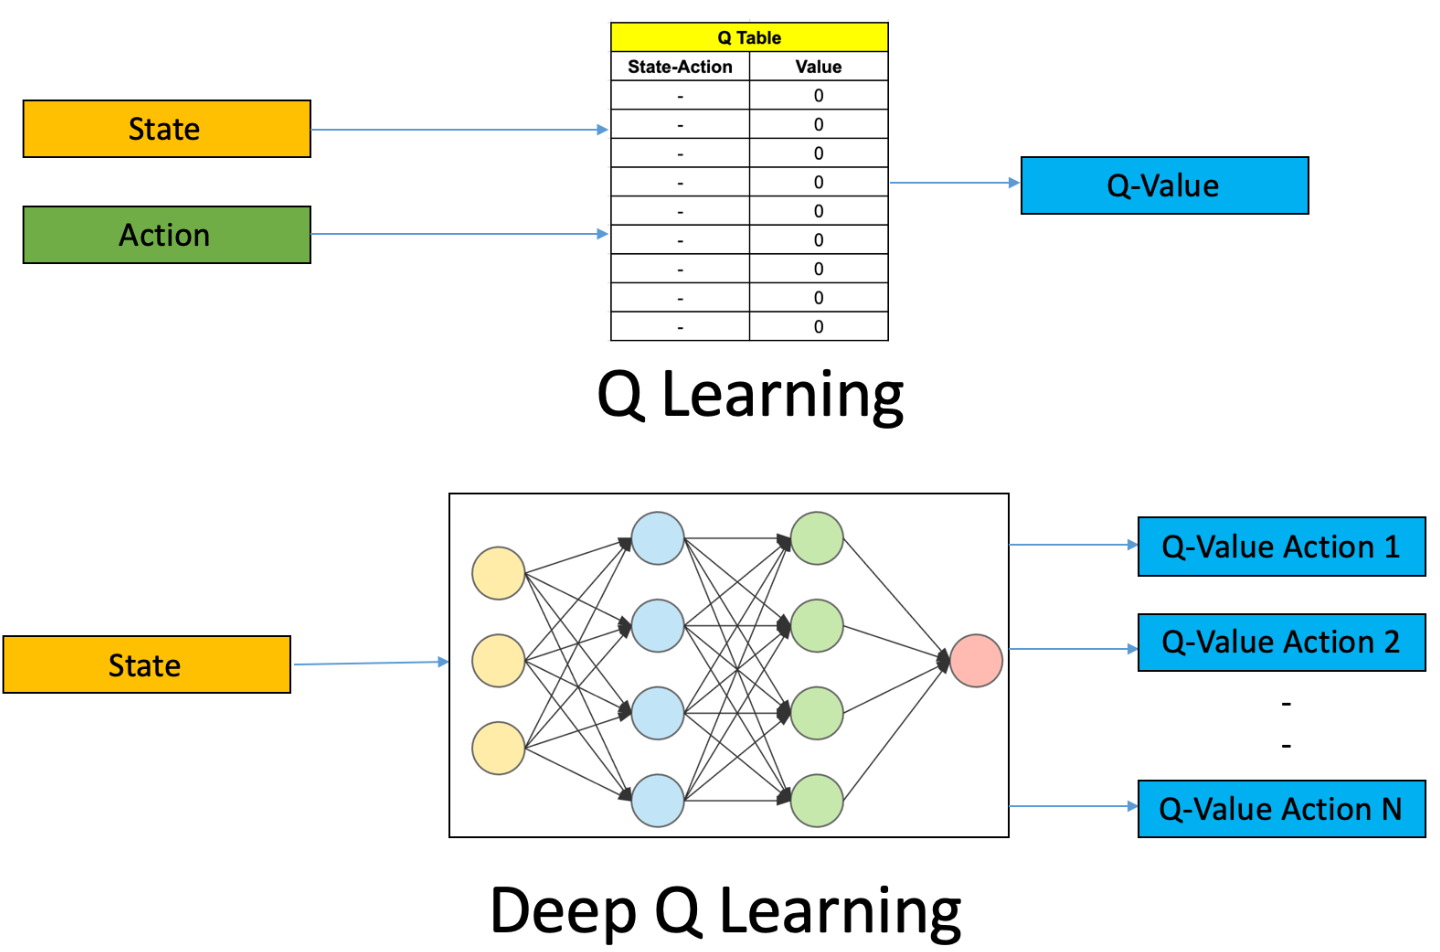

<img src="https://valohai.com/blog/reinforcement-learning-tutorial-part-1-q-learning/image4.png" width="500">
<img src="https://valohai.com/blog/reinforcement-learning-tutorial-basic-deep-q-learning/4.png" width="500">


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Допишите класс `ReplayMemory` для хранения переходов между состояниями.

- [ ] Проверено на семинаре

In [1]:
from collections import namedtuple, deque
import random

Transition = namedtuple(
    'Transition',
    ('state', 'action', 'next_state', 'reward', 'done')
)

class ReplayMemory(object):
    def __init__(self, capacity):
        """capacity - максимальный размер хранилища"""
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)
    
    def push(self, *args):
        """Сохраняет переход. При нехватке места в хранилище самые старые записи удаляются."""
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        """Возвращает batch_size случайно выбранных переходов"""
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

<p class="task" id="2"></p>

2\. Допишите класс `DQN` для моделирования Q-функции.

- [ ] Проверено на семинаре

In [2]:
import torch.nn as nn

class DQN(nn.Module):
    """Нейронная сеть для моделирования Q-функции."""
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        """Для каждого состояния должны получать n_actions чисел."""
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

<p class="task" id="3"></p>

3\. Допишите классы `PolicyConfig` для настроек политики агента и `Policy` для реализации политики.

- [ ] Проверено на семинаре

In [3]:
from dataclasses import dataclass
import torch as th

@dataclass
class PolicyConfig:
    """Содержит настройки для Policy: размерность пространства наблюдений, кол-во действий,
    устройство, на котором будет располагаться модели; ε и т.д."""
    n_observations: int
    n_actions: int
    device: str = 'cpu'
    epsilon_start: float = 1.0
    epsilon_end: float = 0.05
    epsilon_decay: int = 5000
    gamma: float = 0.99

In [4]:
import numpy as np

class Policy:
    def __init__(self, policy_cfg: PolicyConfig):
        self.policy_network = DQN(policy_cfg.n_observations, policy_cfg.n_actions).to(policy_cfg.device)
        self.target_network = DQN(policy_cfg.n_observations, policy_cfg.n_actions).to(policy_cfg.device)
        self.sync_models()

        self.epsilon = policy_cfg.epsilon_start
        self.epsilon_start = policy_cfg.epsilon_start
        self.epsilon_end = policy_cfg.epsilon_end
        self.epsilon_decay = policy_cfg.epsilon_decay
        self.gamma = policy_cfg.gamma
        self.n_actions = policy_cfg.n_actions
        self.device = policy_cfg.device
        self.steps_done = 0

    def sync_models(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())

    def get_best_action(self, state: th.Tensor) -> int:
        sample = random.random()
        self.steps_done += 1
        
        self.epsilon = max(
            self.epsilon_end,
            self.epsilon_start - (self.epsilon_start - self.epsilon_end) * self.steps_done / self.epsilon_decay
        )
        if sample < self.epsilon:
            return random.randrange(self.n_actions)
        else:
            with th.no_grad():
                return self.policy_network(state).argmax(dim=1).item()

    def save(self, path_policy: str, path_target: str):
        th.save(self.policy_network.state_dict(), path_policy)
        th.save(self.target_network.state_dict(), path_target)

    def load(self, path_policy: str, path_target: str):
        self.policy_network.load_state_dict(th.load(path_policy, map_location=self.device))
        self.target_network.load_state_dict(th.load(path_target, map_location=self.device))

<p class="task" id="4"></p>

4\. Напишите функцию `plot_metrics`, которая будет использоваться для визуализации процесса обучения: суммарной награды за каждый эпизод и максимальное значение x-координаты машины за эпизод. Для реализации можете воспользоваться `wandb` или любым другим удобным инструментом.

- [ ] Проверено на семинаре

In [5]:
import matplotlib.pyplot as plt

def plot_metrics(episode_rewards, max_x_positions, window=100):
    plt.figure(figsize=(14,6))

    plt.subplot(1, 2, 1)
    rewards = np.array(episode_rewards)
    if len(rewards) >= window:
        rewards_smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(rewards)), rewards_smoothed, label=f'Награда (скользящее ср. {window})')
    else:
        plt.plot(rewards, label='Награда')
    plt.title('Награда за эпизод')
    plt.xlabel('Эпизод')
    plt.ylabel('Суммарная награда')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    max_x = np.array(max_x_positions)
    if len(max_x) >= window:
        max_x_smoothed = np.convolve(max_x, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(max_x)), max_x_smoothed, label=f'Макс. X (скользящее ср. {window})', color='orange')
    else:
        plt.plot(max_x, label='Макс. X', color='orange')
    plt.title('Максимальное положение за эпизод')
    plt.xlabel('Эпизод')
    plt.ylabel('X координата')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

<p class="task" id="5"></p>

5\. Допишите классы `TrainConfig` для настроек обучения и `Trainer` для реализации процесса обучения.

- [ ] Проверено на семинаре

In [6]:
@dataclass
class TrainConfig:
    """Содержит настройки для процесса обучения: к-т дисконтирования, скорость обучения,
    количество эпизодов для обучения, размер батча и т.д."""
    gamma: float = 0.99
    learning_rate: float = 1e-3
    num_episodes: int = 2500
    batch_size: int = 64
    target_sync: int = 100
    memory_capacity: int = 10000
    max_steps_per_episode: int = 325

In [7]:
import gymnasium as gym
from torch import optim

class Trainer:
    def __init__(self, env: gym.Env, train_config: TrainConfig, policy: Policy):
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(policy.policy_network.parameters(), lr=train_config.learning_rate)

        self.memory = ReplayMemory(train_config.memory_capacity)
        self.env = env
        self.train_config = train_config
        self.policy = policy
        self.episode_rewards = []
        self.max_x_positions = []

    def train(self):
        for episode in range(self.train_config.num_episodes):
            state, _ = self.env.reset()

            state = th.tensor(state, dtype=th.float32, device=self.policy.device).unsqueeze(0)

            total_reward = 0.0
            max_x = -float('inf')

            state, total_reward, max_x = self.run_episode(state)

            self.episode_rewards.append(total_reward)
            self.max_x_positions.append(max_x)

            if episode % 250 == 0 and episode > 0:
                plot_metrics(self.episode_rewards, self.max_x_positions)

            if episode % self.train_config.target_sync == 0 and episode > 0:
                self.policy.sync_models()

            if max_x >= 0.5:
                print(f'Флаг на эпизоде {episode}!')
                self.policy.save('policy_network.pth', 'target_network.pth')

        plot_metrics(self.episode_rewards, self.max_x_positions)

    def run_episode(self, start_state: th.Tensor):
        state = start_state
        total_reward = 0.0
        max_x = -float('inf')

        for t in range(self.train_config.max_steps_per_episode):
            action = self.policy.get_best_action(state)

            next_state, reward, done, truncated, _ = self.env.step(action)

            if next_state[0] >= 0.5:
                reward += 100.0

            total_reward += reward
            max_x = max(max_x, next_state[0])

            next_state_tensor = th.tensor(next_state, dtype=th.float32, device=self.policy.device).unsqueeze(0)

            done_flag = done or truncated
            self.memory.push(state, action, next_state_tensor, reward, done_flag)

            state = next_state_tensor

            self.generate_batch_and_fit()
            
            if done_flag:
                break

        return state, total_reward, max_x

    def generate_batch_and_fit(self):
        if len(self.memory) < self.train_config.batch_size:
            return

        transitions = self.memory.sample(self.train_config.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = th.cat(batch.state)
        action_batch = th.tensor(batch.action, dtype=th.long, device=self.policy.device).unsqueeze(1)
        reward_batch = th.tensor(batch.reward, dtype=th.float32, device=self.policy.device).unsqueeze(1)
        next_state_batch = th.cat(batch.next_state)
        done_batch = th.tensor(batch.done, dtype=th.float32, device=self.policy.device).unsqueeze(1)

        current_q_values = self.policy.policy_network(state_batch).gather(1, action_batch)

        with th.no_grad():
            next_q_values = self.policy.target_network(next_state_batch).max(1)[0].unsqueeze(1)
        expected_q_values = reward_batch + (self.train_config.gamma * next_q_values * (1 - done_batch))

        self.fit_policy_network(current_q_values, expected_q_values)

    def fit_policy_network(self, current_q_values, expected_q_values):
        self.optimizer.zero_grad()
        loss = self.criterion(current_q_values, expected_q_values)
        loss.backward()
        self.optimizer.step()

<p class="task" id="6"></p>

6\. Настройте модель для управления машиной в окружении `MountainCar-v0`. Для преобразования векторов состояний в тензоры используйте обертку `TransformObservation`. Выведите на экран график с информацией о процессе обучения. При необходимости вставьте скриншоты этих графиков.

- [ ] Проверено на семинаре

In [8]:
from gymnasium.wrappers import TransformObservation, RecordVideo

In [9]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
env = RecordVideo(env, episode_trigger=lambda x: x%25== 0, video_folder='videos')
env = TransformObservation(env, lambda obs: obs, observation_space=env.observation_space)

In [10]:
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

policy_cfg = PolicyConfig(
    n_observations=n_observations,
    n_actions=n_actions,
    device='cpu',
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=5000,
    gamma=0.99
)
policy = Policy(policy_cfg)

train_cfg = TrainConfig(
    gamma=0.99,
    learning_rate=1e-3,
    num_episodes=2500,
    batch_size=64,
    target_sync=100,
    memory_capacity=10000,
    max_steps_per_episode=325
)
trainer = Trainer(env, train_cfg, policy)

In [ ]:
trainer.train()
env.close()

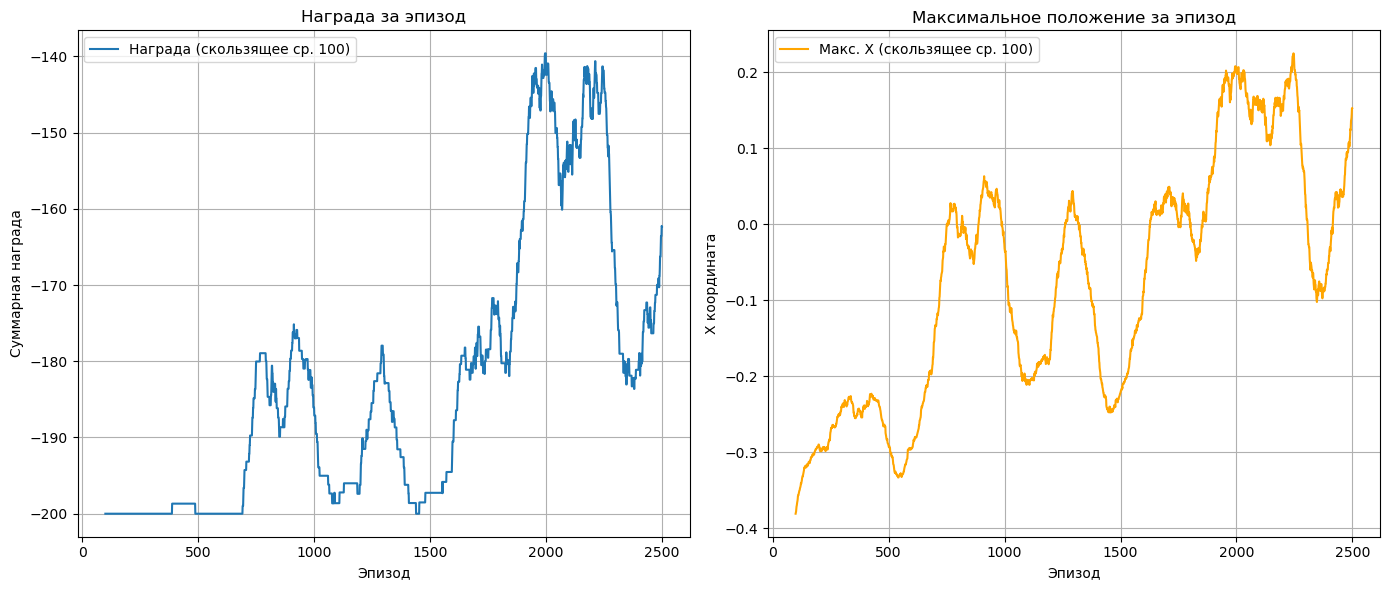

In [12]:
plot_metrics(trainer.episode_rewards, trainer.max_x_positions)

<video controls src="rl-video-episode-2350.mp4" title="Title"></video>